Source:
- https://github.com/abhinavsagar/breast-cancer-classification/blob/master/Breast_cancer_classification.ipynb

## Libraries

In [1]:
import json
import math
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import gc
import itertools

from PIL import Image
from functools import partial
from sklearn import metrics
from collections import Counter
from keras import backend as K
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

from keras import layers
from tensorflow.keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
import numpy as np
import json
import utils_nn_eval
import random
import gc
import pandas
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import cohen_kappa_score, accuracy_score

In [3]:
figure_path = 'D:/FH/Kurse/semester_3/medical_imaging/Medical_Imaging_Elias/Figures/'

## Load Images

### Ground Truth Images

In [4]:
benign = utils_nn_eval.get_all_images('gan_benign')
malignant = utils_nn_eval.get_all_images('gan_malignant')

In [5]:
print(len(benign))
print(len(malignant))

300
300


In [6]:
random.Random(4).shuffle(benign)
random.Random(4).shuffle(malignant)

## Create Split

In [7]:
X_test, Y_test, x_train, x_val, y_train, y_val = utils_nn_eval.create_split(benign, malignant)

## Display Images

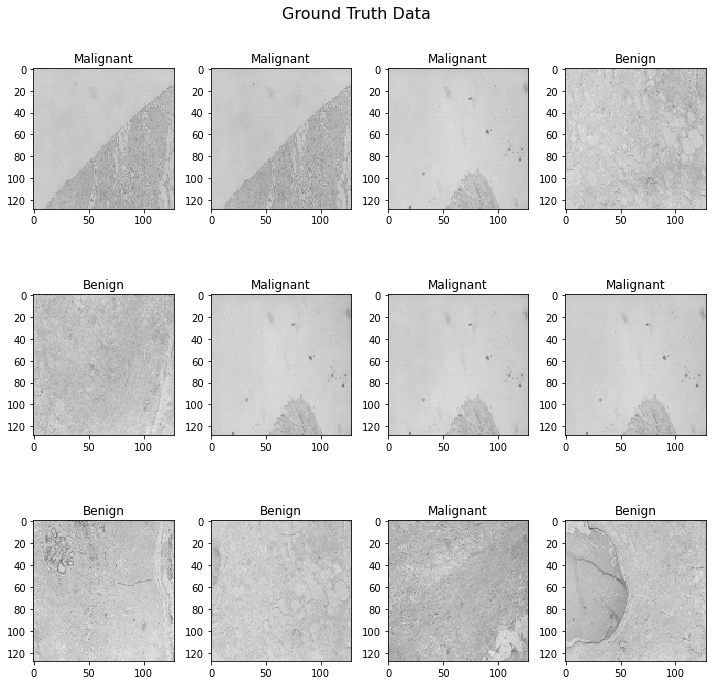

In [8]:
utils_nn_eval.display_images(x_train, y_train, "Ground Truth Data")

## Data Generator

In [9]:
train_generator = utils_nn_eval.create_train_generator()

## Model Creation

In [10]:
def build_model(backbone, lr = 1e-4):

    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation = 'softmax'))
    
    
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate = lr),
        metrics = ['accuracy']
    )
    
    return model

In [11]:
K.clear_session()
gc.collect()

shape = (128, 128, 3)

resnet = DenseNet201(
                        weights = 'imagenet',
                        include_top = False,
                        input_shape = shape
                    )

model = build_model(resnet , lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


## Training & Evaluation

In [12]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath = "densenet_mix_local.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [13]:
history = model.fit(

    train_generator.flow(x_train, y_train, batch_size = 16),
    steps_per_epoch=x_train.shape[0] / 16,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
24/24 [==============================] - 52s 1s/step - loss: 0.6039 - accuracy: 0.6823 - val_loss: 0.8503 - val_accuracy: 0.4375

Epoch 00001: val_accuracy improved from -inf to 0.43750, saving model to densenet_new_local.hdf5
Epoch 2/50
24/24 [==============================] - 33s 1s/step - loss: 0.3999 - accuracy: 0.8438 - val_loss: 0.6889 - val_accuracy: 0.7188

Epoch 00002: val_accuracy improved from 0.43750 to 0.71875, saving model to densenet_new_local.hdf5
Epoch 3/50
24/24 [==============================] - 33s 1s/step - loss: 0.2971 - accuracy: 0.8750 - val_loss: 0.4797 - val_accuracy: 0.8125

Epoch 00003: val_accuracy improved from 0.71875 to 0.81250, saving model to densenet_new_local.hdf5
Epoch 4/50
24/24 [==============================] - 34s 1s/step - loss: 0.2305 - accuracy: 0.9115 - val_loss: 0.4406 - val_accuracy: 0.6771

Epoch 00004: val_accuracy did not improve from 0.81250
Epoch 5/50
24/24 [==============================] - 34s 1s/step - loss: 0.2306 - acc

In [14]:
with open('densenet_gan-data.json', 'w') as f:
    
    json.dump(str(history.history), f)

In [15]:
model.save('./densenet_gan-data')

INFO:tensorflow:Assets written to: ./densenet_gan-data\assets


## Prediction on Ground Truth Data

In [17]:
filepath_model = "./densenet_gan_local.hdf5"
model.load_weights(filepath_model)

In [18]:
Y_val_pred = model.predict(x_val)

In [19]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

1.0

In [20]:
save_weights

NameError: name 'save_weights' is not defined